In [4]:
%%capture
import math
import numpy as np
# from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io.wavfile as wave
import glob as glob
import pandas as pd
import os
import os.path
import time
from IPython.display import clear_output
from numpy.fft import fft
import librosa
from IPython.display import Audio
from ipywidgets import interactive
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D,Conv2D, LeakyReLU, Flatten, GlobalAveragePooling1D,GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow import keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, ReLU, Flatten
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model  import RidgeCV,LassoCV 
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
os.environ['LIBROSA_CACHE_DIR'] = '/tmp/librosa_cache'
os.environ['LIBROSA_CACHE_LEVEL']='20'

from tqdm import tqdm # code pour afficher une barre de chargement il faut installer la librairie tqdm pour qu'il marche

from google.colab import drive
drive.mount('/content/drive')

In [5]:
#sauvegarde d'un modèle
# model_bin.save('modele_bin_slider_coco.joblib')

#boucle d'enregistrement des spectres 
def enregistrement_npy(dt=256):
  for machine in df.Machine.unique():
      #Génération de spectres
      df_train = df[ (df['Machine']== machine) & (df['train_test'] == 'train') ] # sélection de la machine 
      df_valid = df[ (df['Machine']== machine) & (df['train_test'] == 'test') ] # sélection de la machine 

      #partie non testée pour adapter l'URL au google drive
      URLS_train=[]
      URLS_valid=[]
      for lignes in df_train['URL']:
        URLS_train.append(str("/content/drive/MyDrive/Datascience projet son/"+lignes))
      for lignes in df_valid['URL']:
        URLS_valid.append(str("/content/drive/MyDrive/Datascience projet son/"+lignes))

      data_train = load_data(URLS_train, dt=dt, T_max=10,normalize=True)
      data_valid = load_data(URLS_valid, dt=dt, T_max=10,normalize=True)
      
      # on cherche la puissance de 2 la plus proche du nb fréquence
      carre=2
      while carre<data_train.shape[2]:
          carre*=2
      
      freq=int(carre/2)
      
      #Reduction de dimension
      sel=downsizing()      
      sel.fit(data_train,seuil_db=False,nb_freq=freq)
      data_train=sel.transform(data_train,normalize=False)
      data_valid=sel.transform(data_valid,normalize=False)

      #Enregistrement
      nom_fichier_train=str(str(machine)+"_train_norm_"+str(dt)+"_"+str(freq)+".npy")
      nom_fichier_test=str(str(machine)+"_test_norm_"+str(dt)+"_"+str(freq)+".npy")

      np.save(nom_fichier_train,data_train.flatten())
      np.save(nom_fichier_test,data_valid.flatten())
  return

#chargement des données en entrée
def load_data(audio_path, dt=0.5, T_max=10, normalize=False):
    """
    Permet de charger un spectre logmel depuis un path. 
    
    params: 
    
    dt: float /int. si [0:1[ alors dt est considéré comme un pas de découpage en seconde 
        si >=1 alors doit être un int réprésentant le nombre de découpages souhaité
    
    """
    X_audio=[]
    
    if dt<1: # on veut selectionner le pas en seconde
        with tqdm(total=len(audio_path)) as pbar: # code pour afficher une barre de chargement
            for i, a_path in enumerate(audio_path) :
                pbar.update(1) # permet de mettre la barre de chargement à jour en ajoutant 1 itération
                # Load the audio file
                data, fe = librosa.load(a_path, sr=None)

                # For the audio > T_max : Use just the fist T_max seconde, to have the right shape. 
                if len(data)>= T_max*fe:
                    data = data[:int(T_max*fe)]

                # For the audio < T_max : Add in the signal a zeros vector, to have the right shape.
                else :
                    data = np.concatenate([data, np.zeros(int(T_max*fe - len(data)))])

                # Apply the logMelSpectrogram function.    
                spectre_audio = logMelSpectrogram(data, fe, dt)
                if normalize : 
                    spectre_audio=(np.array(spectre_audio)-np.array(spectre_audio).min())/(np.array(spectre_audio).max()-np.array(spectre_audio).min())
                    X_audio.append(spectre_audio)
            
        
    else: # on veut selectionner un nombre de dt 
        with tqdm(total=len(audio_path)) as pbar:
            for a_path in audio_path :
                pbar.update(1)
                # Load the audio file
                data, fe = librosa.load(a_path, sr=None)

                # For the audio > T_max : Use just the fist T_max seconde, to have the right shape. 
                if len(data)>= T_max*fe:
                    data = data[:int(T_max*fe)]

                # For the audio < T_max : Add in the signal a zeros vector, to have the right shape.
                else :
                    data = np.concatenate([data, np.zeros(int(T_max*fe - len(data)))])

                # Apply the logMelSpectrogram function. 

                spectre_audio = logMelSpectrogram(data[:(len(data)//dt)*dt], fe, np.around(T_max/dt,3))
                spectre_audio=spectre_audio[:dt,:] # on tronque quand même au cas où nous avons dépasser le nombre de dt. 
                if normalize : 
                    spectre_audio=(np.array(spectre_audio)-np.array(spectre_audio).min())/(np.array(spectre_audio).max()-np.array(spectre_audio).min())

                X_audio.append(spectre_audio)
                if np.array(X_audio).shape[1]!=dt:
                  raise Exception("Erreur le nombre de dt réalisé ne coincide pas avec la demande, changer le nombre demandé \n" "format actuel de sortie",np.array(X_audio).shape)
    
        return np.array(X_audio)

#Générateur de spectre
class spectrum_generator():
    def __init__(self):
        self.level=0
        self.v_translate=0
        self.cut=None
        self.nb_freq=0
        self.nb_dt=0
        self.nb_samples_tot=0
        self.nb_samples_target=0
        
    def fit(self,X,y,level=0,v_translate=0,dt_cut=None):
        #récupération des paramètres
        self.level=level
        self.v_translate=v_translate
        self.nb_samples_tot,self.nb_dt,self.nb_freq=X.shape
        
        if dt_cut=='first':
            self.cut=0
        elif dt_cut=='last':
            self.cut=-1
        elif dt_cut=='both':  
            self.cut=[0,-1]
        else :
            self.cut=None
        
    def flow_from_numpy(self,X,y,batchsize=32,pourcent_modif=0.1):
        #initialisation de la selection aléatoire des samples
        selector=np.random.random(batchsize)*self.nb_samples_tot
        selector=selector.astype(int)
        transform_sel=np.random.random(int(pourcent_modif*batchsize))*selector.shape
        transform_sel=transform_sel.astype(int)
        #sélection des samples
        X_selected=np.array(X)[selector]
        y_selected=np.array(y)[selector]
        #transformation aléatoire des samples via une des fonctions
        for modif in transform_sel:
            choix_modif=int(np.random.random(1)*3)
            if choix_modif<=1:
                X_selected[modif,:,:]=X_selected[modif,:,:]*(1+(self.level*np.random.random(1))-(self.level*np.random.random(1))) # on multiplie le spectre par une valeur 1+- self.level
           
            elif (choix_modif>1) and (choix_modif<=2):
                X_selected[modif,:,:]=X_selected[modif,:,:]+(self.v_translate*np.random.random(1))-(self.v_translate*np.random.random(1))# on ajoute au spectre une valeur 1+- self.v_translate
            
            elif (choix_modif>2) and (choix_modif<=3):
                for dt in self.cut:
                    X_selected[modif,dt,:]=X_selected[modif,dt,:]*0
            else:
                X_selected[modif,:,:]=X_selected[modif,:,:]
        
        return X_selected,y_selected
        
    def add_samples(self,X,y,pourcent_add=0.1, labels='all'):
        self.nb_samples_tot=y.shape[0]
        if labels=='all':
            self.nb_samples_target=self.nb_samples_tot
        else:
            self.nb_samples_target=y[y==labels].shape[0]
        
        if self.nb_samples_target ==self.nb_samples_tot : 
            #initialisation de la selection aléatoire des samples
            selector=np.random.random(int(pourcent_add*self.nb_samples_tot))*self.nb_samples_tot
            selector=selector.astype(int)
            #sélection des samples
            X_selected=np.array(X)[selector]
            y_selected=np.array(y)[selector]
        
        else :
            selector=np.random.random(int(pourcent_add*self.nb_samples_target))*self.nb_samples_target
            selector=selector.astype(int)
            #sélection des samples
            X_selected=np.array(X)[y==labels][selector]
            y_selected=np.array(y)[y==labels][selector]
        
        #transformation aléatoire des samples via une des fonctions
        for modif in range(X_selected.shape[0]):
            choix_modif=int(np.random.random(1)*3)
            if choix_modif<=1:
                X_selected[modif,:,:]=X_selected[modif,:,:]*(1+self.level)
           
            elif (choix_modif>1) and (choix_modif<=2):
                X_selected[modif,:,:]=X_selected[modif,:,:]*(1-self.level)  
            
            elif (choix_modif>2) and (choix_modif<=3):
                for dt in self.cut:
                    X_selected[modif,dt,:]=X_selected[modif,dt,:]*0
            else:
                X_selected[modif,:,:]=X_selected[modif,:,:]
        
        return np.concatenate((X,X_selected),axis=0),np.concatenate((y,y_selected),axis=0)   
        

#création du masque
class downsizing():
    def __init__(self):
        self.selector=0
        self.datamax=0
    
    def fit(self,X,seuil_db=False,nb_freq=False):
        self.datamax=X.max(axis=1).max(axis=0)
        if (seuil_db!=False) and (nb_freq!=False):
                return print('Renseignez un seuil_db OU un nombre de fréquences à garder mais pas les deux')

        elif seuil_db=='brute':
            #Méthode brute
            data_s=X.sum(axis=1).sum(axis=0)
            data_s.shape
            self.selector=np.where(data_s>0,True,False)  
        elif seuil_db!=False:  
            self.selector=np.where(self.datamax>seuil_db,True,False)

        elif nb_freq!=False:  
            self.selector=np.where(self.datamax>np.sort(self.datamax)[-(nb_freq+1)],True,False) # on est très restrictif dans un premier temps 

            if np.sum(self.selector)<nb_freq:
                self.selector=np.where(self.datamax>=np.sort(self.datamax)[-(nb_freq+1)],True,False) # si nous avons été trop restrictif, alors nous élargissons la selection puis nous bouclons pour supprimer le surplus

            iter=100
            while np.sum(self.selector)>nb_freq and iter>0: # En cas de multiples valeurs similaires on boucle pour les supprimer et ne garder que la dim voulue
                print('Trop de fréquences choisies, suppression de {:} fréquences pour atteindre la taille cible'.format( self.selector.sum()-nb_freq))
                self.selector[np.argsort(np.sort(self.datamax[self.selector]))[-1]]=False  # on récupère la position du plus petit élément de datamax pour la supprimer du sélector
                iter-=1 # on met 10 itérations pour éviter de boucler à l'infini en cas d'erreur
        print('nombre de fréquences gardées: ', self.selector.sum())
        
    def transform(self,X,normalize=False):
        
        if normalize:
            def normalisation(ligne2D):
                return (np.array(ligne2D)-np.array(ligne2D).min())/(np.array(ligne2D).max()-np.array(ligne2D).min())  
            
            X_select=X[:,:,self.selector]
            X_select=np.array([ normalisation(samples) for samples in X_select ])
            return X_select
        
        else :
            return X[:,:,self.selector]
    
    
    def get_selector(self,seuil_db):
        self.selector=np.where(self.datamax>seuil_db,True,False)
        return self.selector
    
    
    def get_datamax(self):
        return self.datamax

    
def logMelSpectrogram(audio, fe, dt):
    stfts = np.abs(librosa.stft(audio,n_fft = int(dt*fe),hop_length = int(dt*fe),center = True)).T
    num_spectrogram_bins = stfts.shape[-1]
    # MEL filter
    linear_to_mel_weight_matrix = librosa.filters.mel(sr=fe,n_fft=int(dt*fe) + 1,n_mels=num_spectrogram_bins,).T
    # Apply the filter to the spectrogram
    mel_spectrograms = np.tensordot(stfts,linear_to_mel_weight_matrix,1)
    return np.log(mel_spectrograms + 1e-6)

def plot_logMelSpectrogram(audio, fe, dt=0.025):
    sns.heatmap(np.rot90(logMelSpectrogram(audio, fe, dt)), cmap='inferno', vmin = -6)
    loc, labels = plt.xticks()
    l = np.round((loc-loc.min())*len(audio)/fe/loc.max(), 2)
    plt.xticks(loc, l)
    plt.yticks([])
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Mel)")
    

    
# permet de lire et de récupérer les données d'un fichier wav
def wave_path(machine,folder,type_audio,k):
    machine_path='./'+machine+'/'
    type_path=folder+'/'
    zeros='00000000'+str(k)
    file_name=type_audio+'_id_00_'+zeros[-8:]+'.wav'
    file_path=machine_path+type_path+file_name
    rate,data = wave.read(file_path)
    graph_name=file_name.split('.')[0]+'_spectre.jpg'
    save_path=machine_path+'Spectres/'+graph_name
    n = data.size
    duree = 1.0*n/rate
    return file_path,save_path,n,duree,rate,data

# permet de faire la transformée de Fourier et de tracer le spectre d'un signal
def tracerSpectre_op(data,rate,debut,duree):
    start = int(debut*rate)
    stop = int((debut+duree)*rate)
    # Récupération de la valeur absolue de la transformée de fourier sur l'échantillon
    spectre = np.absolute(fft(data[start:stop]))
    # normalisation des valeurs 0/1
    spectre = spectre/spectre.max()
    # On crée les labels des abscices 
    n = spectre.size
    freq=np.linspace(1/n,1,n)*rate
    # On trace un barplot avec x=freq,y=spectre
    plt.vlines(freq,[0],spectre,'r')
    plt.xlabel('f (Hz)')
    plt.ylabel('A')
    plt.axis([0,0.5*rate,0,1])
    plt.grid()
    
#permet de faire la transformée de fourrier sur le signal
def Fourier(data,rate,debut,duree):
    start = int(debut*rate)
    stop = int((debut+duree)*rate)
    # Récupération de la valeur absolue de la transformée de fourier sur l'échantillon
    spectre = np.absolute(fft(data[start:stop]))
    # normalisation des valeurs 0/1
    spectre = spectre/spectre.max()
    # On crée les labels des abscices 
    n = spectre.size
    freq=np.linspace(1/n,1,n)*rate
    return freq,spectre

#permet de faire la transformée de fourrier sur le signal
def Frequences(data,rate):
    n = data.size
    duree = 1.0*n/rate
    start = int(0)
    stop = int(duree*rate)
    # Récupération de la valeur absolue de la transformée de fourier sur l'échantillon
    spectre = np.absolute(fft(data[start:stop]))
    # normalisation des valeurs 0/1
    spectre = spectre/spectre.max()
    return spectre

  #Algorythme de parcours de fichier
def Dossier_data(DOSSIER):
    """
    Cette fonction permet de parcourir les fichiers contenu 
    dans le DOSSIER 'DOSSIER' QUE VOUS SOUHAITEZ du notebook d'en extraire
    les informations et de générer un PandaDataFrame
    """
    if DOSSIER!='':
        chemin=glob.glob(''+DOSSIER+'/**',recursive=True)
    else :
        chemin=glob.glob('/**',recursive=True)
    
    df=pd.DataFrame(chemin, columns=['URL'])
    df['URL2']=df['URL'].apply(lambda contenu: os.path.split(contenu)[0])
    df['fichier']=df['URL'].apply(lambda contenu: os.path.split(contenu)[1])
    df['train_test']=df['URL2'].apply(lambda contenu: os.path.split(contenu)[1])
    df['URL2']=df['URL2'].apply(lambda contenu: os.path.split(contenu)[0])
    df['Machine']=df['URL2'].apply(lambda contenu: os.path.split(contenu)[1])
    df=df[(df['Machine']!='')&(df['Machine']!='.')&(df['Machine']!='Datascience_projet_son')&(df['Machine']!='./archive')&(df['URL2']!='./archive')]
    df['Machine_ID']=df['fichier'].apply(lambda contenu: contenu.split('_')[2])
    df['son_type']=df['fichier'].apply(lambda contenu: contenu.split('_')[0])
    df=df.drop('URL2',axis=1)
    duree=[]
    nb_boucles=df.shape[0]
    tps1 = time.time()
    for i,URL in enumerate(df['URL']):
      tps2 = time.time()
      print('boucle: ',i+1 ,' / ', nb_boucles+1)
      print('temps écoulé:{:.2f} sec'.format(tps2 - tps1))
      print('temps restant:{:.0f} min'.format((tps2 - tps1)*(nb_boucles-i)/((i+1)*60)))
      duree.append(duration(URL))
      clear_output()
      if i%1000==0 : # on supprime le cache de la RAM toutes les 1000 itérations
        librosa.cache.clear()

    df['duree_son']=duree
    tps3 = time.time()
    print('temps total:',tps3 - tps1)
    return df




#Création du CSV
# df.to_csv('Fichiers_son.csv')
#Changement de l'ordre
# df=df.reindex(columns=['URL','fichier','fichier_type','Machine','Machine_ID','son_type','rate','spectre'])

In [6]:
# df['URL2']=str(str(df.Machine)+"/"+str(df.train_test)+"/"+str(df.fichier))
df=pd.read_csv('/content/drive/MyDrive/Datascience projet son/Fichiers_son.csv')
df

,Unnamed: 0,URL,fichier,train_test,Machine,Machine_ID,son_type,duree_son
0,3,archive/ToyCar/test/normal_id_02_00000055.wav,normal_id_02_00000055.wav,test,ToyCar,2,normal,11.0
1,4,archive/ToyCar/test/normal_id_02_00000064.wav,normal_id_02_00000064.wav,test,ToyCar,2,normal,11.0
2,5,archive/ToyCar/test/normal_id_02_00000031.wav,normal_id_02_00000031.wav,test,ToyCar,2,normal,11.0
3,6,archive/ToyCar/test/normal_id_02_00000027.wav,normal_id_02_00000027.wav,test,ToyCar,2,normal,11.0
4,7,archive/ToyCar/test/normal_id_02_00000024.wav,normal_id_02_00000024.wav,test,ToyCar,2,normal,11.0
...,...,...,...,...,...,...,...,...
30982,31001,archive/valve/train/normal_id_00_00000316.wav,normal_id_00_00000316.wav,train,valve,0,normal,10.0
30983,31002,archive/valve/train/normal_id_00_00000305.wav,normal_id_00_00000305.wav,train,valve,0,normal,10.0
30984,31003,archive/valve/train/normal_id_00_00000282.wav,normal_id_00_00000282.wav,train,valve,0,normal,10.0
30985,31004,archive/valve/train/normal_id_00_00000320.wav,normal_id_00_00000320.wav,train,valve,0,normal,10.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# IMPORT DES FICHIERS
freq=256
dt=256
normal_val=0
anomaly_val=1

machine='pump'
EPOCHS=600
#liens chargement enregistrement 
path_train='/content/drive/MyDrive/Projet datascientest/'+machine+'_train_norm_'+str(dt)+'_'+str(freq)+'.npy'
path_test='/content/drive/MyDrive/Projet datascientest/'+machine+'_test_norm_'+str(dt)+'_'+str(freq)+'.npy'


#Sélection des données
df_fan_train = df[ (df['Machine']== machine) & (df['train_test'] == 'train') ] # sélection de la machine fan
df_fan_test = df[ (df['Machine']== machine) & (df['train_test'] == 'test') ] # sélection de la machine fan
y_son_train= np.array(df_fan_train['son_type'])

#importation des fichiers npy
data_train = np.load(path_train)
data_valid = np.load(path_test)

#reshaping
data_train=data_train.reshape(-1,dt,freq)
data_valid=data_valid.reshape(-1,dt,freq)
data=np.concatenate((data_train,data_valid))

print("Avant ajout: ", data_train.shape)
#ajout de samples
generator=spectrum_generator()
generator.fit(data_train,y_son_train,level=0.1,v_translate=0.5,dt_cut='both')
X_train,y_train=generator.add_samples(data_train,y_son_train,pourcent_add=0.5, labels='all')
print("Après ajout: ", X_train.shape)



Avant ajout:  (3349, 256, 256)
Après ajout:  (5023, 256, 256)


### AUTO ENCODEUR FONCTIONNEL

In [12]:
# modèle AE fonctionnel A FAIRE TOURNER
import keras
from keras import layers

data_train = data_train.reshape((-1, dt, freq, 1))

input_sound = keras.Input(data_train.shape[1:])



# decoded = layers.Conv2D(1, (3, 3), padding='same')(x)
# x = layers.Conv2D(128, (3, 3), activation='relu',padding='same')(input_sound)
# x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_sound)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), padding='same')(x)

autoencoder3D_AUG = keras.Model(input_sound, decoded)


autoencoder3D_AUG.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 256, 256, 64)      640       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 16)        4624      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 16)        0   

In [13]:
autoencoder3D_AUG.compile(optimizer='adam', loss='mse')
from keras.callbacks import ModelCheckpoint
autosave_path='/content/drive/MyDrive/Datascience projet son/Astrid/AE_'+machine+".hdf5"

checkpoint = ModelCheckpoint(autosave_path, monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=10)

# autoencoder3D_AUG=keras.models.load_model('best_model.hdf5')
# autoencoder3D_AUG.load_weights('Auto_save_fan_256_256.hdf5')
history3D_AUG = autoencoder3D_AUG.fit(data_train, data_train,
                                     epochs=EPOCHS,
                                     batch_size=32,
                                     shuffle=True,
                                     max_queue_size=10,
                                     workers=4,use_multiprocessing=True,
                                     validation_split=0.2,callbacks=[checkpoint])

Epoch 1/600
84/84 [==============================] - 25s 103ms/step - loss: 0.1026 - val_loss: 0.0042
Epoch 2/600
84/84 [==============================] - 8s 90ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 3/600
84/84 [==============================] - 8s 90ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 4/600
84/84 [==============================] - 8s 90ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 5/600
84/84 [==============================] - 8s 90ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 6/600
84/84 [==============================] - 8s 90ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 7/600
84/84 [==============================] - 8s 90ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 8/600
84/84 [==============================] - 8s 90ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 9/600
84/84 [==============================] - 8s 90ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 10/600
84/84 [==============================] - 8s 90ms/step - loss: 0.0030 - val_loss: 0.00

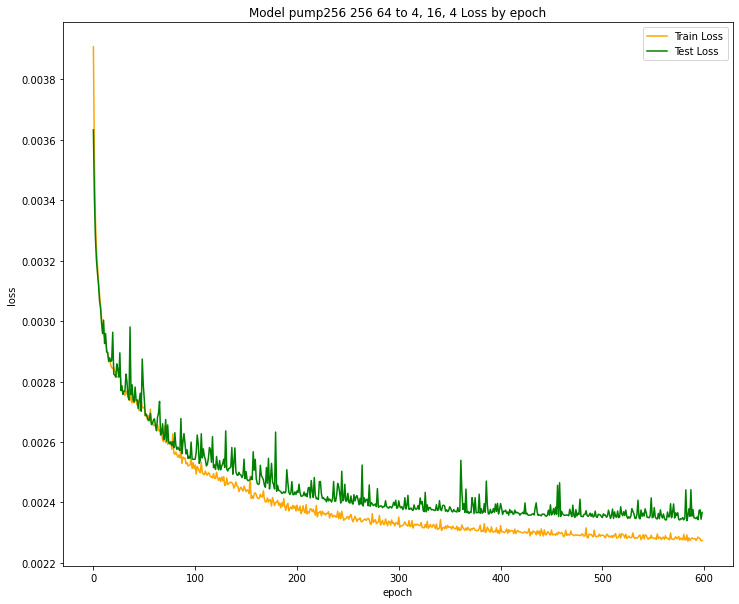

In [14]:
figures_path='/content/drive/MyDrive/Datascience projet son/Astrid/'
plt.figure(figsize=(12,10))
plt.plot(history3D_AUG.history['loss'][1:],'orange' ,label = 'Train Loss',)
plt.plot(history3D_AUG.history['val_loss'][1:],'g', label = 'Test Loss')
plt.title('Model ' + machine+ str(dt) +" " + str(freq) +' 64 to 4, 16, 4 Loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig(figures_path + 'AE_trained_on_'+machine+'.png')

In [15]:
#sauvegarde d'un modèle
model_save_path='/content/drive/MyDrive/Datascience projet son/Astrid/AE_trained_on'+machine+'.joblib'
autoencoder3D_AUG.save(model_save_path)

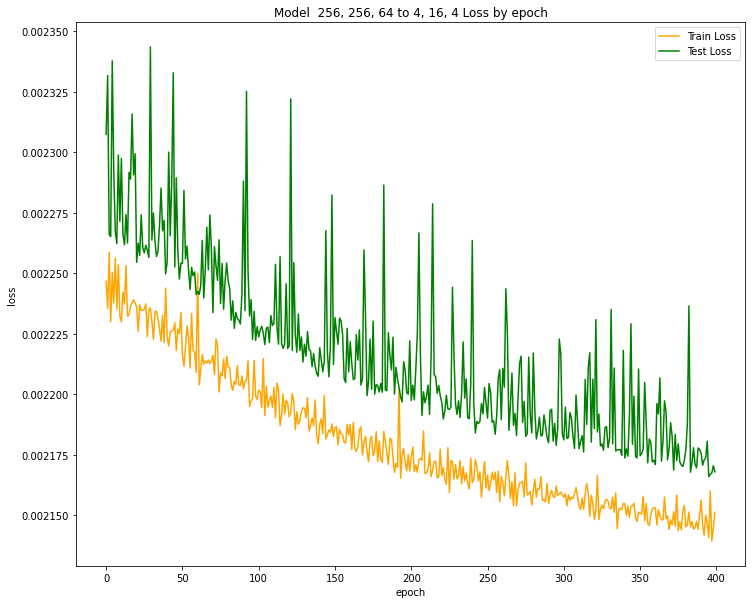

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(history3D_AUG.history['loss'][200:],'orange' ,label = 'Train Loss',)
plt.plot(history3D_AUG.history['val_loss'][200:],'g', label = 'Test Loss')
plt.title('Model  256, 256, 64 to 4, 16, 4 Loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

In [ ]:
#on réalise les prédictions
pred_3d=autoencoder3D_AUG.predict(data_valid)
pred_3d=pred_3d.reshape(-1, dt, freq)
#on calcule la MSE
from sklearn.metrics import mean_squared_error
from scipy import stats
score_3D=[]
with tqdm(total=y_norm_valid.shape[0]) as pbar:
    for pred, true in zip(pred_3d,data_valid):
        score_3D.append(mean_squared_error(true,pred))
        pbar.update(1)

score_3D_graph=pd.DataFrame(y_norm_valid)
score_3D_graph['MSE']=np.array(score_3D)
score_3D_graph.columns=['son_type','MSE']
print(stats.ttest_ind(score_3D_graph[score_3D_graph.son_type=='anomaly']['MSE'],score_3D_graph[score_3D_graph.son_type=='normal']['MSE']))

score_3D_graph[score_3D_graph.son_type=='normal'].plot.hist(alpha=0.5)
plt.title('normal')
score_3D_graph[score_3D_graph.son_type=='anomaly'].plot.hist(alpha=0.5)
plt.title('anomaly');

1875it [00:00, 2368.72it/s]


ValueError: ignored

In [ ]:
data_valid = np.load('/content/drive/MyDrive/Datascience projet son/LogMel/fan_test_norm_256_256.npy')
data_valid=data_valid.reshape(-1,256,freq)
data_valid.shape

(1875, 256, 256)

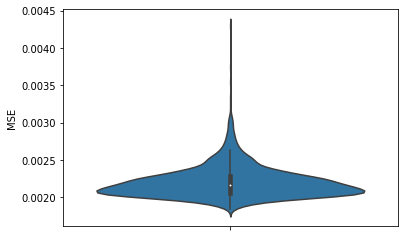

In [ ]:
# sns.violinplot(score_3D_graph[score_3D_graph.son_type=='normal']['MSE'],score_3D_graph[score_3D_graph.son_type=='anomaly']['MSE']);

sns.violinplot(data=score_3D_graph.replace(['normal','anomaly'],[0,1]),y='MSE',hue='son_type',split=True);


In [ ]:
score_3D_graph.replace(['normal','anomaly'],[0,1])

,son_type,MSE
0,1,0.003853
1,1,0.003829
2,1,0.003301
3,1,0.002777
4,1,0.003078
...,...,...
1870,1,0.002836
1871,1,0.003311
1872,1,0.003266
1873,1,0.003520


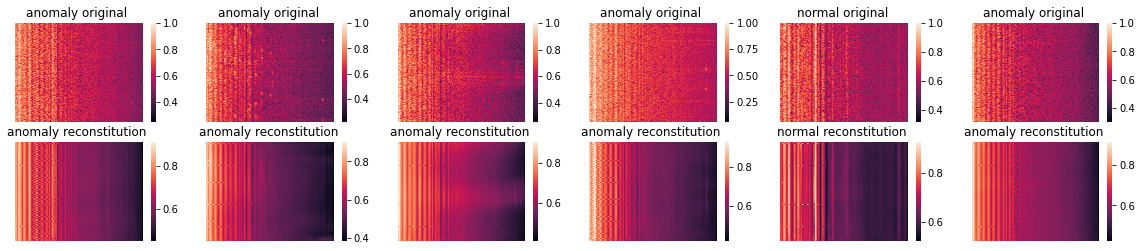

In [ ]:
nb_to_plot=6
select=[np.random.random(nb_to_plot)*y_norm_valid.shape[0]]
select=np.array(select).astype('int').reshape(nb_to_plot)
plt.figure(figsize=(20,4))
for i in range (1,nb_to_plot+1):
  ax1=plt.subplot(2,nb_to_plot,i)
  # ax1.imshow(data_valid_cut[select[i-1]])
  sns.heatmap(data_valid[select[i-1]])
  plt.title(y_norm_valid[select[i-1]] + ' original ')
  ax1.get_yaxis().set_visible(False)
  ax1.get_xaxis().set_visible(False)
  ax2=plt.subplot(2,nb_to_plot,i+nb_to_plot)
  # ax2.imshow(pred_3d[select[i-1]])
  sns.heatmap(pred_3d[select[i-1]])
  plt.title(y_norm_valid[select[i-1]] +' reconstitution ')
  ax2.get_yaxis().set_visible(False)
  ax2.get_xaxis().set_visible(False)
  # plt.legend()
plt.show()


In [ ]:
select=[np.random.random(nb_to_plot)*y_norm_valid.shape[0]]
select=np.array(select).astype('int').reshape(nb_to_plot)
select

array([1519,  495,  905, 1174,  870,  611])

In [ ]:
#sauvegarde d'un modèle
autoencoder3D_AUG.save(model_save_path)


### ESSAIS CATEGORISATION

In [ ]:
labels=np.concatenate((y_norm_train,y_norm_valid))
data=np.concatenate((data_train,data_valid))

X_train,X_test,y_train_labels,y_test_labels=train_test_split(data,labels,test_size=0.2, random_state=1,shuffle=True)
y_train=pd.DataFrame(y_train_labels).replace(['normal','anomaly'],[normal_val,anomaly_val])
y_test=pd.DataFrame(y_test_labels).replace(['normal','anomaly'],[normal_val,anomaly_val])

#ajout de samples
generator=spectrum_generator()
generator.fit(X_train,y_train,level=0.1,v_translate=0.5,dt_cut='both')
X_gen,y_gen=generator.add_samples(X_train,y_train,pourcent_add=0.5, labels=anomaly_val)
print(X_train.shape)
print(X_gen.shape)

(4440, 256, 256)
(6660, 256, 256)


In [ ]:
import keras
from keras import layers

data_train = X_gen.reshape((-1, dt, freq, 1))

input_sound = keras.Input(data_train.shape[1:])

act='sigmoid'
loss='binary_crossentropy'
EPOCHS=500
BATCH=64
autosave_path='/content/drive/MyDrive/Datascience projet son/Corentin/Auto_save_classifier_fan_256_256.hdf5'

#on charge le modèle pré-entrainé
encoded = tf.keras.models.load_model('/content/drive/MyDrive/Datascience projet son/Corentin/autoencoder3D_0506_fan_256dt_600E.joblib')
#on freeze les poids
for l in encoded.layers:
  l.trainable=False


#adaptateur
adaptateur=layers.Flatten()(encoded.layers[9].output)
# Classification part
x=layers.Dense(64)(adaptateur)
x=layers.Dropout(0.5)(x)
x=layers.ReLU()(x)

x=layers.Dense(128)(x)
x=layers.Dropout(0.5)(x)
x=layers.ReLU()(x)

x=layers.Dense(256)(x)
x=layers.Dropout(0.5)(x)
x=layers.ReLU()(x)

classificateur=layers.Dense(1, activation=act)(x)

concatenated_input=tf.keras.layers.Concatenate([encoded.layers[9].output, input_sound], axis=-1)
ClassificateurFlatten = keras.Model(concatenated_input, classificateur)

ClassificateurFlatten.summary()


TypeError: ignored

In [ ]:
model_bin.compile(loss=loss, optimizer=opt, metrics=[metric])
checkpoint = ModelCheckpoint(autosave_path, monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=10)
history_bin = model_bin.fit(X_gen, y_gen, validation_data=(X_test, y_test), 
                            verbose=2, batch_size=BATCH, epochs=EPOCHS,shuffle=True,
                            callbacks = [checkpoint],max_queue_size=30,
                            workers=1,use_multiprocessing=True)


model_bin_pred=model_bin.predict(X_test)
# y_pred_bin=model_bin_pred.argmax(axis=1)
if model_bin_pred.min()<0:
    y_pred_bin=np.where(model_bin_pred<0,-1,1)
else:
    y_pred_bin=np.where(model_bin_pred>0.5,1,0)

clefs=list(history_bin.history.keys())    
y_true=y_test
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history_bin.history[clefs[1]],'g:',label='train')
plt.plot(history_bin.history[clefs[3]],'g--',label='eval')
plt.legend()
plt.subplot(1,2,2)
y_true_text=np.array(pd.DataFrame(y_true).replace([normal_val,anomaly_val],['normal','anomaly'])).reshape(y_true.shape[0])
y_pred_bin=np.array(pd.DataFrame(y_pred_bin).replace([normal_val,anomaly_val],['normal','anomaly']))
sns.heatmap(pd.crosstab(y_true_text,y_pred_bin.reshape(y_pred_bin.shape[0]),rownames=['Classe réelle'], colnames=['Classe prédite'],normalize='index'),annot=True,cmap='Blues',vmax=0.05);
print(metrics.classification_report(y_true_text,y_pred_bin))

In [ ]:
X_gen = X_gen.reshape((-1, dt, freq, 1))
X_test = X_test.reshape((-1, dt, freq, 1))
input_sound = keras.Input(X_gen.shape[1:])

act='sigmoid'
loss='binary_crossentropy' #SquaredHinge
metric='accuracy'
opt='adam'
EPOCHS=500
BATCH=64
autosave_path='/content/drive/MyDrive/Datascience projet son/Corentin/Auto_save_classifier_fan_256_256.hdf5'

#on charge le modèle pré-entrainé
encoded = tf.keras.models.load_model('/content/drive/MyDrive/Datascience projet son/Corentin/autoencoder3D_0506_fan_256dt_600E.joblib')
#on freeze les poids
for l in encoded.layers:
  l.trainable=False

model_bin = Sequential(encoded.layers[:11])

#on ajoute l'ancien modèle
# model_bin.add()

model_bin.add(Flatten())
# Classification part
model_bin.add(Dense(1024))
model_bin.add(Dropout(0.2))
model_bin.add(LeakyReLU())
model_bin.add(Dense(1024))
model_bin.add(Dropout(0.2))
model_bin.add(LeakyReLU())
model_bin.add(Dense(1, activation='sigmoid'))

model_bin.compile(loss=loss, optimizer=opt, metrics=[metric])
# model_bin.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(autosave_path, monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=10)
history_bin = model_bin.fit(X_gen, y_gen, validation_data=(X_test, y_test), 
                            verbose=2, batch_size=BATCH, epochs=EPOCHS,shuffle=True,
                            callbacks = [checkpoint],max_queue_size=30,
                            workers=1,use_multiprocessing=True)


model_bin_pred=model_bin.predict(X_test)
# y_pred_bin=model_bin_pred.argmax(axis=1)
if model_bin_pred.min()<0:
    y_pred_bin=np.where(model_bin_pred<0,-1,1)
else:
    y_pred_bin=np.where(model_bin_pred>0.5,1,0)

clefs=list(history_bin.history.keys())    
y_true=y_test
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history_bin.history[clefs[1]],'g:',label='train')
plt.plot(history_bin.history[clefs[3]],'g--',label='eval')
plt.legend()
plt.subplot(1,2,2)
y_true_text=np.array(pd.DataFrame(y_true).replace([normal_val,anomaly_val],['normal','anomaly'])).reshape(y_true.shape[0])
y_pred_bin=np.array(pd.DataFrame(y_pred_bin).replace([normal_val,anomaly_val],['normal','anomaly']))
sns.heatmap(pd.crosstab(y_true_text,y_pred_bin.reshape(y_pred_bin.shape[0]),rownames=['Classe réelle'], colnames=['Classe prédite'],normalize='index'),annot=True,cmap='Blues',vmax=0.05);
print(metrics.classification_report(y_true_text,y_pred_bin))

Epoch 1/500
105/105 - 184s - loss: 0.5798 - accuracy: 0.7381 - val_loss: 0.5937 - val_accuracy: 0.7243
Epoch 2/500


KeyboardInterrupt: ignored

In [ ]:
# Entrainement sur TPU
import os
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
# resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)
# tf.contrib.distribute.initialize_tpu_system(resolver)
# strategy = tf.contrib.distribute.TPUStrategy(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
tpu_model = tf.distribute.keras_to_tpu_model(
    model_bin,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)
tpu_model.compile(optimizer=opt,loss=loss,metrics=metric)
 
def train_gen(batch_size):
  while True:
    offset = np.random.randint(0, x_train.shape[0] - batch_size)
    yield X_gen[offset:offset+batch_size], y_train[offset:offset + batch_size]
     
 
tpu_model.fit_generator(train_gen(64),epochs=1,steps_per_epoch=1000,validation_data=(X_test, y_test),)

INFO:tensorflow:Initializing the TPU system: grpc://10.57.236.154:8470
INFO:tensorflow:Clearing out eager caches
INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


AttributeError: ignored

ESSAIS AE

In [ ]:
# modèle AE DROPOUT
import keras
from keras import layers

data_train = data_train.reshape((-1, dt, freq, 1))

input_sound = keras.Input(data_train.shape[1:])



# decoded = layers.Conv2D(1, (3, 3), padding='same')(x)
# x = layers.Conv2D(128, (3, 3), activation='relu',padding='same')(input_sound)
# x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_sound)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), padding='same')(x)

autoencoder3D_AUG = keras.Model(input_sound, decoded)


autoencoder3D_AUG.summary()

## ESSAIS AE double conv

In [ ]:
# modèle AE DOUBLE CONV
import keras
from keras import layers

import keras
from keras import layers

X_train = X_train.reshape((-1, dt, freq, 1))
# X_test = X_test.reshape((-1, dt, freq, 1))
input_sound = keras.Input(X_train.shape[1:])


act='sigmoid'
loss='mse' #SquaredHinge
metric='mse'
opt='adam'
EPOCHS=100
BATCH=64
autosave_path='/content/drive/MyDrive/Datascience projet son/Corentin/Auto_save_AEDOUBLE_fan_256_256.hdf5'

import keras
from keras import layers

data_train = data_train.reshape((-1, dt, freq, 1))

input_sound = keras.Input(data_train.shape[1:])



# decoded = layers.Conv2D(1, (3, 3), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_sound)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), padding='same')(x)

autoencoder_DOUBLE = keras.Model(input_sound, decoded)


autoencoder_DOUBLE.summary()

autoencoder_DOUBLE.compile(loss=loss, optimizer=opt)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 128, 128, 32)      18464     
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 64, 64, 32)        0   

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(autosave_path, monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=10)
history_AE = autoencoder_DOUBLE.fit(X_train, X_train, validation_split=0.2, 
                            verbose=1, batch_size=BATCH, epochs=EPOCHS,shuffle=True,
                            callbacks = [checkpoint],max_queue_size=30,
                            workers=4,use_multiprocessing=True)

Epoch 1/100
69/69 [==============================] - 84s 1s/step - loss: 0.1035 - val_loss: 0.0057
Epoch 2/100
69/69 [==============================] - 82s 1s/step - loss: 0.0043 - val_loss: 0.0045
Epoch 3/100
69/69 [==============================] - 82s 1s/step - loss: 0.0037 - val_loss: 0.0041
Epoch 4/100
69/69 [==============================] - 82s 1s/step - loss: 0.0035 - val_loss: 0.0038
Epoch 5/100
69/69 [==============================] - 82s 1s/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/100
69/69 [==============================] - 82s 1s/step - loss: 0.0032 - val_loss: 0.0033
Epoch 7/100
69/69 [==============================] - 82s 1s/step - loss: 0.0031 - val_loss: 0.0033
Epoch 8/100
69/69 [==============================] - 82s 1s/step - loss: 0.0031 - val_loss: 0.0033
Epoch 9/100
69/69 [==============================] - 82s 1s/step - loss: 0.0031 - val_loss: 0.0032
Epoch 10/100
69/69 [==============================] - 82s 1s/step - loss: 0.0031 - val_loss: 0.0033

Epoch 00

KeyboardInterrupt: ignored

100%|██████████| 1875/1875 [00:01<00:00, 1733.69it/s]


Ttest_indResult(statistic=-0.6948641722725569, pvalue=0.487226615073445)


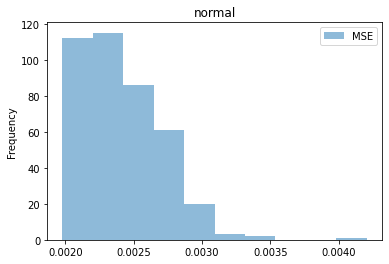

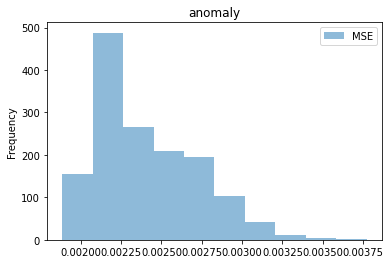

In [ ]:
#on réalise les prédictions
pred_3d=autoencoder_DOUBLE.predict(data_valid)
pred_3d=pred_3d.reshape(-1, dt, freq)
#on calcule la MSE
from sklearn.metrics import mean_squared_error
from scipy import stats
score_3D=[]
with tqdm(total=y_norm_valid.shape[0]) as pbar:
    for pred, true in zip(pred_3d,data_valid):
        score_3D.append(mean_squared_error(true,pred))
        pbar.update(1)

score_3D_graph=pd.DataFrame(y_norm_valid)
score_3D_graph['MSE']=np.array(score_3D)
score_3D_graph.columns=['son_type','MSE']
print(stats.ttest_ind(score_3D_graph[score_3D_graph.son_type=='anomaly']['MSE'],score_3D_graph[score_3D_graph.son_type=='normal']['MSE']))

score_3D_graph[score_3D_graph.son_type=='normal'].plot.hist(alpha=0.5)
plt.title('normal')
score_3D_graph[score_3D_graph.son_type=='anomaly'].plot.hist(alpha=0.5)
plt.title('anomaly');

In [ ]:
autoencoder_DOUBLE.save('autoencoder_DOUBLE_fan_256.joblib')

CODE JAPONAIS

In [ ]:
#code de transformation d'un fichier Japonais

def file_to_vector_array(file_name,
                         n_mels=64,
                         frames=5,
                         n_fft=1024,
                         hop_length=512,
                         power=2.0):
    """
    convert file_name to a vector array.
    file_name : str
        target .wav file
    return : numpy.array( numpy.array( float ) )
        vector array
        * dataset.shape = (dataset_size, feature_vector_length)
    """
    # 01 calculate the number of dimensions
    dims = n_mels * frames
    # 02 generate melspectrogram using librosa
    y, sr = librosa.load(file_name)
    mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)
    # 03 convert melspectrogram to log mel energy
    log_mel_spectrogram = 20.0 / power * np.log10(mel_spectrogram + sys.float_info.epsilon)
    # 04 calculate total vector size
    vector_array_size = len(log_mel_spectrogram[0, :]) - frames + 1
    # 05 skip too short clips
    if vector_array_size < 1:
        return np.empty((0, dims))
    # 06 generate feature vectors by concatenating multiframes
    vector_array = np.zeros((vector_array_size, dims))
    for t in range(frames):
        vector_array[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + vector_array_size].T
    return vector_array


#Essais sur des fichiers 
URL_normal=df_fan_test[(df_fan_test.Machine_ID==4) &(df_fan_test.son_type=='normal')]['URL'][:6]
URL_anomalie=df_fan_test[(df_fan_test.Machine_ID==4) &(df_fan_test.son_type=='anomaly')]['URL'][:6]
spectres_normaux=[]
for URL in tqdm(URL_normal):
    spectres_normaux.append(file_to_vector_array(URL))
spectres_normaux=np.array(spectres_normaux)

spectres_anomalie=[]
for URL in tqdm(URL_anomalie):
    spectres_anomalie.append(file_to_vector_array(URL))
spectres_anomalie=np.array(spectres_anomalie)
nb_to_plot=6
plt.figure(figsize=(20,4))
for i in range (1,nb_to_plot):
  ax1=plt.subplot(2,nb_to_plot,i)
  # ax1.imshow(data_valid_cut[select[i-1]])
  sns.heatmap(spectres_normaux[i])
  plt.title(' normal ')
  ax1.get_yaxis().set_visible(False)
  ax1.get_xaxis().set_visible(False)
  
  ax2=plt.subplot(2,nb_to_plot,i+nb_to_plot)
  # ax2.imshow(pred_3d[select[i-1]])
  sns.heatmap(spectres_anomalie[i])
  plt.title(' anormal ')
  ax2.get_yaxis().set_visible(False)
  ax2.get_xaxis().set_visible(False)
  # plt.legend()
plt.show()